In [1]:
# !pip install geoplotlib
# !pip install folium --user
# !pip install geopandas --user

### Cities are not alike. 

This notebook steps through the process of finding a clone city and comparing gaps between a city(Houston was chosen) vs its clone.

Import relevant modules

In [34]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from collections import defaultdict
import pandabase
import seaborn as sns

### Download files and get top cities

In [30]:
with open('df_complete.pickle','rb') as read_file:
    df_complete = pickle.load(read_file)
    
with open('cuisine_topic_info.pickle','rb') as read_file:
    cuisine_topic_info = pickle.load(read_file)
    
with open('dish_topic_info.pickle','rb') as read_file:
    dish_topic_info = pickle.load(read_file)

In [31]:
# clean the city labels
df_complete['city'] = df_complete['city'].apply(lambda x: x.strip())

# group df with city and their km_labels
df_cities = df_complete.groupby(['city','km_label']).agg({'row_number':'count','rating_count':['sum','mean','median']}).reset_index()
df_cities.columns = ['city','km_label','count','sum_reviews','mean_reviews','median_reviews']

These are the biggest cities

In [32]:
df_cities.groupby('city')['count'].sum().reset_index().sort_values(by='count',ascending=False)[:10]

,city,count
553,New York,3273
139,Chicago,1974
91,Brooklyn,1904
465,Los Angeles,1488
634,Philadelphia,1041
358,Houston,697
508,Miami,643
87,Bronx,517
734,Seattle,513
649,Portland,464


## Inference: Finding cities most similar to Houston

There are four steps to finding gaps to a city (in this concrete example, we are using Houston):

[**Step 1:** Define Topic Importance](#step1)\
[**Step 2:** Find Distance Between Houston and City<sup>n</sup>](#step2)\
[**Step 3:** Find Houston's sisters](#step3)\
[**Step 4:** Compare Houston to its Clone](#step4)

<a class="anchor" id="step1"></a>

### Step 1: Define Topic Importance

We define Topic Importance using this formula: 

(Median_cnt_rating<sub>i</sub> X Count_restaurant<sub>i</sub>) / Total_Restaurants

The following steps are: 
1. Getting median reviews for each topic, by city
1. Getting count of restaurants for each topic, by city
1. Multiply median reviews and count of restaurants (step 1 & step 2) 
1. Divide step 3 with Total Restaurants

1. Getting median reviews for each topic, by city

In [62]:
# Getting median reviews in each topic importance, by cities
city_median = df_cities.pivot(index='city',columns='km_label',values='median_reviews').reset_index().fillna(0)
city_median = city_median.set_index('city')
city_median.head()

km_label,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
city,,,,,,,,,,,,,,,,,,,,,
ATLANTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abington,0.0,0.0,0.0,0.0,0.0,0.0,21.0,2534.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Addison,63.0,58.0,0.0,113.0,0.0,110.0,30.0,546.0,0.0,0.0,...,0.0,0.0,354.0,39.0,110.0,45.0,99.5,0.0,0.0,0.0
Adelphi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agoura Hills,169.5,16.0,126.0,0.0,0.0,253.0,10.0,168.0,0.0,0.0,...,39.0,0.0,54.0,43.0,1.0,178.0,0.0,0.0,0.0,0.0


2. Getting count of restaurants for each topic, by city

In [61]:
city_count = df_cities.pivot(index='city',columns='km_label',values='count').reset_index().fillna(0)
city_count = city_count.set_index('city')
city_count.head()

km_label,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
city,,,,,,,,,,,,,,,,,,,,,
ATLANTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abington,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Addison,1.0,1.0,0.0,3.0,0.0,3.0,6.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0
Adelphi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Agoura Hills,2.0,1.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,...,1.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0


3. Multiply median reviews and count of restaurants (step 1 & step 2)

In [8]:
# Multiplying city by their median reviews
city_cnt_median_multiply = np.multiply(city_count, city_median)
city_cnt_median_multiply[:2]

km_label,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
city,,,,,,,,,,,,,,,,,,,,,
ATLANTA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Abington,0.0,0.0,0.0,0.0,0.0,0.0,21.0,2534.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


4. Divide step 3 with Total Restaurants

In [67]:
# We are now getting Topic Importance
summation = np.array(city_cnt_median_multiply.sum(axis = 1, skipna = True))

city_topic_perc = np.array(city_cnt_median_multiply)/summation[:,None]
city_topic_perc_df =pd.DataFrame(city_topic_perc, index=city_cnt_median_multiply.index)

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


Before we analyze further let's select the top 30 cities to work with

In [70]:
# let's get the top cities
# Houston is #21, which makes most of these cities candidates
top_cities = city_cnt_median_multiply.sum(axis = 1, skipna = True).sort_values(ascending=False)[:30] # we define 30 as top
top_cities[:10]

city
New York        1447090.0
Brooklyn         990156.0
Chicago          581290.0
Philadelphia     490961.0
Bronx            253875.0
Astoria          182855.0
Los Angeles      148585.0
Denver           110499.0
Washington        89496.0
Jersey City       85075.0
dtype: float64

This is the top cities' Topic Importance Score

In [71]:
top_city_topic = pd.merge(city_topic_perc_df,pd.DataFrame(top_cities), how='inner', left_index=True, right_index=True)

Since we're only interested in Houston data, let's do that

In [74]:
# data ex Houston
ex_houston_topic_perc = top_city_topic[top_city_topic.index != 'Houston'] # getting count

# Houston data
houston_topic_perc = top_city_topic[top_city_topic.index =='Houston']

In [79]:
ex_houston_array = np.array(top_city_topic.iloc[:, :-1][top_city_topic.index != 'Houston']) # remove last column, which has median count rating

houston_array = np.array(houston_topic_perc.iloc[:, :-1]) # remove last column, which has median count rating

Plotting Brooklyn against Houston to observe distribution.

It looks like they are very different! 

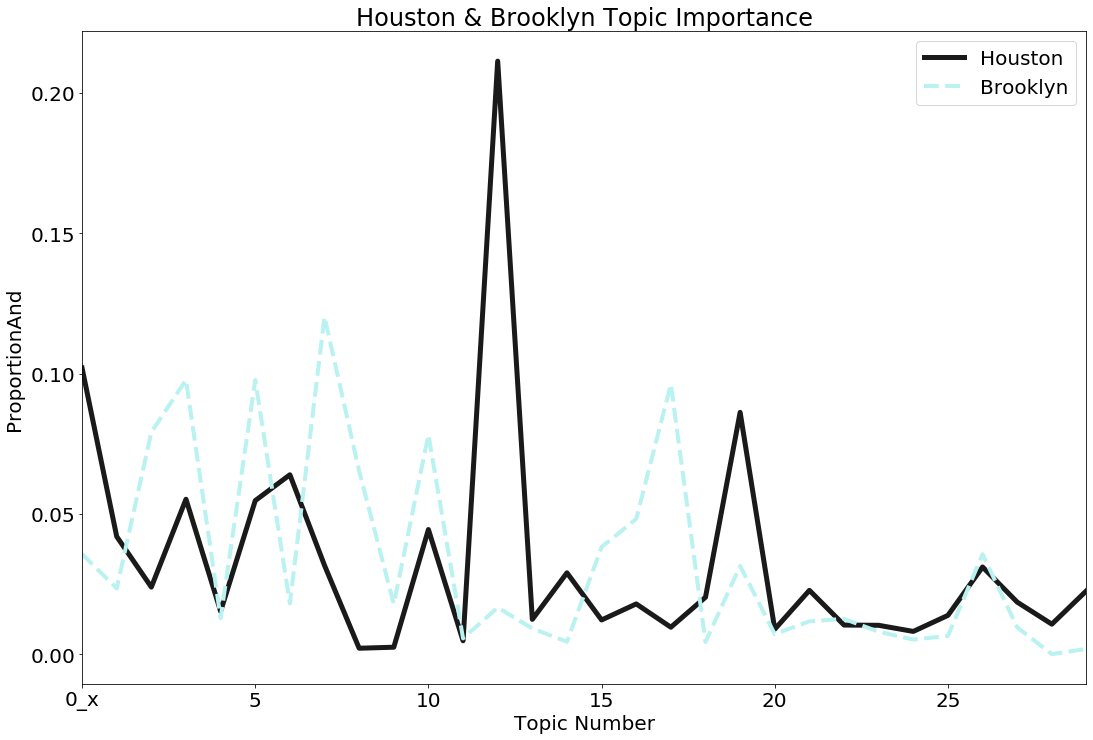

In [87]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

# plotting rest of candidate cities
other_plot_topic = ex_houston_topic_perc.loc[candidate_cities,:].iloc[:, :-1].T.reset_index()

# plotting Houston
houst_plot_topic = houston_topic_perc.iloc[:, :-1].T.reset_index()
houst_plot_topic.plot(kind='line', x='index', y='Houston', linewidth=5, color= 'k', ax=ax);

# comparing plot in New York
NY_plot_topic = ex_houston_topic_perc.loc['Brooklyn',:].iloc[:-1].T.reset_index()
NY_plot_topic.plot(kind='line', x='index', y='Brooklyn', linewidth=4, linestyle = '--', color= 'c', ax=ax);

ax.legend(prop={'size': 20})
# ax.get_legend().remove()
plt.title("Houston & Brooklyn Topic Importance", fontsize=24)
plt.ylabel("ProportionAnd ", fontsize=20)
plt.xlabel("Topic Number", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);


<a class="anchor" id="step2"></a>

### Step 2: Find Distance Between Houston and City<sup>n</sup>

In [88]:
# Calculate distance between Houston and every city
stdev_results = defaultdict(int)

for i in range(len(ex_houston_array)):
    r = np.sqrt(np.sum(np.square(ex_houston_array[i] - houston_array))/30)
    stdev_results[i] = r

In [89]:
# attaching distance calculated with city name
cities_v_houston = pd.concat([pd.Series(stdev_results),pd.Series(ex_houston_topic_perc.index)],axis=1)\
.sort_values(by=0)

<a class="anchor" id="step3"></a>

In [90]:
# These are the 10 closest cities to Houston
cities_v_houston[:10]

,0,city
21,0.026666,Phoenix
8,0.027314,Chicago
24,0.030359,Seattle
22,0.030576,Portland
27,0.031832,Washington
10,0.032339,Denver
3,0.033899,Atlanta
4,0.037603,Boston
9,0.038081,Dallas
19,0.044634,New York


### Step 3: Find Houston's sisters

In [46]:
# choose the top 5 cities as candidate / sister cities
candidate_cities = cities_v_houston['city'][:5]

In [47]:
ex_houston_topic_perc.rename(columns={'0_x':'0'}, inplace=True)
houston_topic_perc.rename(columns={'0_x':'0'}, inplace=True)


/home/ubuntu/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


''

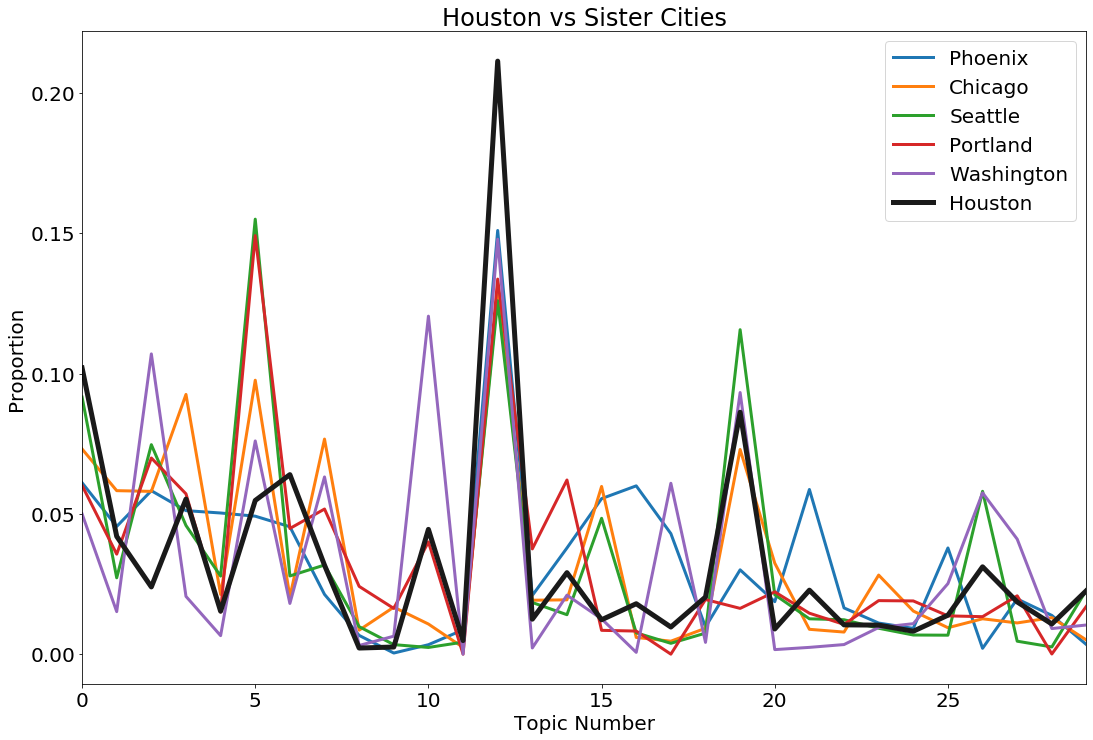

In [48]:
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(1, 1, 1)

# plotting rest of candidate cities
other_plot_topic = ex_houston_topic_perc.loc[candidate_cities,:].iloc[:, :-1].T.reset_index()
other_plot_topic.plot(kind='line',x='index',y=candidate_cities,linewidth=3,ax=ax)

# plotting Houston
houst_plot_topic = houston_topic_perc.iloc[:, :-1].T.reset_index()
houst_plot_topic.plot(kind='line', x='index', y='Houston', linewidth=5, color= 'k', ax=ax);

# comparing plot in New York
# NY_plot_topic = ex_houston_topic_perc.loc['New York',:].iloc[:-1].T.reset_index()
# NY_plot_topic.plot(kind='line', x='index', y='New York', linewidth=4, linestyle = '--', color= 'c', ax=ax);

ax.legend(prop={'size': 20})
# ax.get_legend().remove()
plt.title("Houston vs Sister Cities", fontsize=24)
plt.ylabel("Proportion", fontsize=20)
plt.xlabel("Topic Number", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20);
;


<a class="anchor" id="step4"></a>

### Step 4: Compare Houston to its Clone

In [40]:
## getting topic distance between closest 6 cities and Houston

# create topic importance for Houston clone using the top 6 cities
houston_clone = np.array(ex_houston_topic_perc.loc[candidate_cities,:].iloc[:, :-1].mean(axis=0))

# get topic importance for Houston
houston_weight = np.array(houston_topic_perc.iloc[:, :-1])

# measure difference between houston and clone houston
topic_distance = houston_clone - houston_weight

# attach measured didfference with food topic, to plot
plt_distance = pd.DataFrame(topic_distance.T,index=range(0,30)).reset_index()
plt_distance.columns = ['food_topic','values']

Graph Houston Clone subtract Houston to find Opportunities

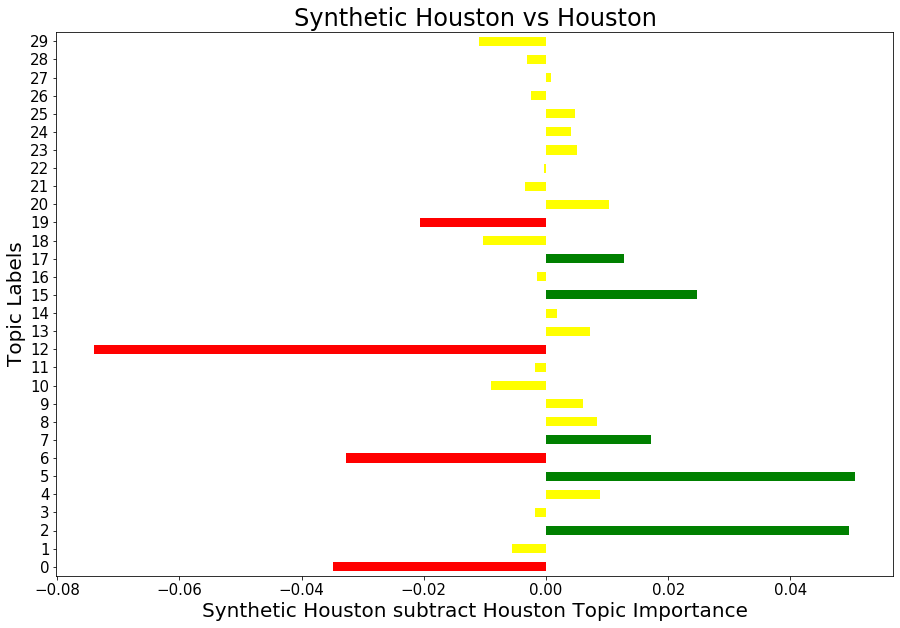

In [26]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1, 1, 1)

sns.set_color_codes("pastel")
color = ['red','yellow','green','yellow','yellow','green','red','green','yellow','yellow','yellow','yellow',
         'red','yellow','yellow','green','yellow','green','yellow','red','yellow','yellow','yellow','yellow',
        'yellow','yellow','yellow','yellow','yellow','yellow',]
plt_distance['values'].plot(ax=ax, kind='barh', title='ranking', color=color)

# ax.get_legend().remove()
plt.title("Synthetic Houston vs Houston", fontsize=24)
plt.ylabel("Topic Labels", fontsize=20)
plt.xlabel("Synthetic Houston subtract Houston Topic Importance", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

